# Welcome to the evaluation notebook

This cell is made, to detect classify and track the pedestrians.

In [4]:
import csv
import torch
from ultralytics import YOLO
import cv2
import os
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort

# Load YOLOv8 model
model = YOLO("/home/teitur/perception/Project/perception-final-project/models/yolov8/trained_model.pt", verbose=False)

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30, n_init=3, nn_budget=100)

# Load timestamps
def load_timestamps(timestamps_file):
    with open(timestamps_file, 'r') as f:
        return [line.strip() for line in f]

# Function to process video, generate detections, and save results to CSV
def process_video(image_dir, output_video_path, output_csv_path, timestamps_file, fps=30):
    images = sorted([img for img in os.listdir(image_dir) if img.endswith(".png")])
    frame = cv2.imread(os.path.join(image_dir, images[0]))
    height, width, _ = frame.shape
    video_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    # Load timestamps
    timestamps = load_timestamps(timestamps_file)
    
    # Dictionary to map track_id to labels
    track_labels = {}
    
    # Open CSV file for writing
    with open(output_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write header row matching the label file format
        writer.writerow([
            "frame", "track_id", "type", "truncated", "occluded", "alpha", 
            "left", "top", "right", "bottom", "height", "width", "length", 
            "x", "y", "z", "rotation_y", "score", "timestamp"
        ])
        
        # Process each frame
        for frame_number, img_name in enumerate(images):
            img_path = os.path.join(image_dir, img_name)
            img = cv2.imread(img_path)
            results = model(img, verbose=False)  # YOLO Inference
            
            # Prepare detections for DeepSORT and map labels to detections
            detections = []
            confidences = []  # Store confidence for each detection
            frame_labels = []  # Store labels for this frame's detections
            for box in results[0].boxes:
                cls = int(box.cls[0])
                label = model.names[cls]
                if label in ["person", "car", "bicycle"]:
                    x1, y1, x2, y2 = [int(b) for b in box.xyxy[0].tolist()]
                    confidence = box.conf[0].item()
                    detections.append(([x1, y1, x2 - x1, y2 - y1], confidence, cls))
                    confidences.append(confidence)
                    frame_labels.append(label)  # Track label for this detection
            
            # Update tracks with DeepSORT
            tracked_objects = tracker.update_tracks(detections, frame=img)
            
            # Annotate frame and write to CSV
            for i, obj in enumerate(tracked_objects):
                if not obj.is_confirmed():  # Only write confirmed tracks
                    continue

                track_id = obj.track_id
                bbox = obj.to_ltrb()  # Left, top, right, bottom format
                # Map track_id to label in this frame
                if track_id not in track_labels:
                    track_labels[track_id] = frame_labels[i] if i < len(frame_labels) else "unknown"
                label = track_labels[track_id]  # Get consistent label for this track ID
                confidence = confidences[i] if i < len(confidences) else 0.0  # Get confidence

                # Placeholder values for missing fields
                truncated = 0  # Adjust as needed
                occluded = 0  # Adjust based on occlusion handling
                alpha = 0.0  # Adjust for observation angle if applicable
                height, width, length = 1.0, 1.0, 1.0  # Replace with 3D dimensions if known
                x, y, z = 0.0, 0.0, 0.0  # Replace with 3D location in camera coordinates if available
                rotation_y = 0.0  # Replace with rotation around Y-axis if calculated
                timestamp = timestamps[frame_number] if frame_number < len(timestamps) else "unknown"

                # Draw bounding box on the video frame
                color = (0, 255, 0)
                cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), 
                              (int(bbox[2]), int(bbox[3])), color, 2)
                text = f"ID {track_id} - {label}"
                cv2.putText(img, text, (int(bbox[0]), int(bbox[1]) - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                
                # Write data to CSV
                writer.writerow([
                    frame_number, track_id, label, truncated, occluded, alpha, 
                    bbox[0], bbox[1], bbox[2], bbox[3], height, width, length, 
                    x, y, z, rotation_y, confidence, timestamp
                ])

            # Write annotated frame to video
            video_writer.write(img)
    
    # Release resources
    video_writer.release()

# Paths for input and output
image_directory = "/home/teitur/perception/Project/34759_final_project_raw/seq_01/image_02/data"
timestamps_file = "/home/teitur/perception/Project/34759_final_project_raw/seq_01/image_02/timestamps.txt"
output_video_path = "tracked_output.mp4"
output_csv_path = "tracking_results.csv"

# Run the video processing function
process_video(image_directory, output_video_path, output_csv_path, timestamps_file, fps=30)


### This cell, is made to compare the perfomance of the trained models, to the untrained models and the labled data we get from the assignment

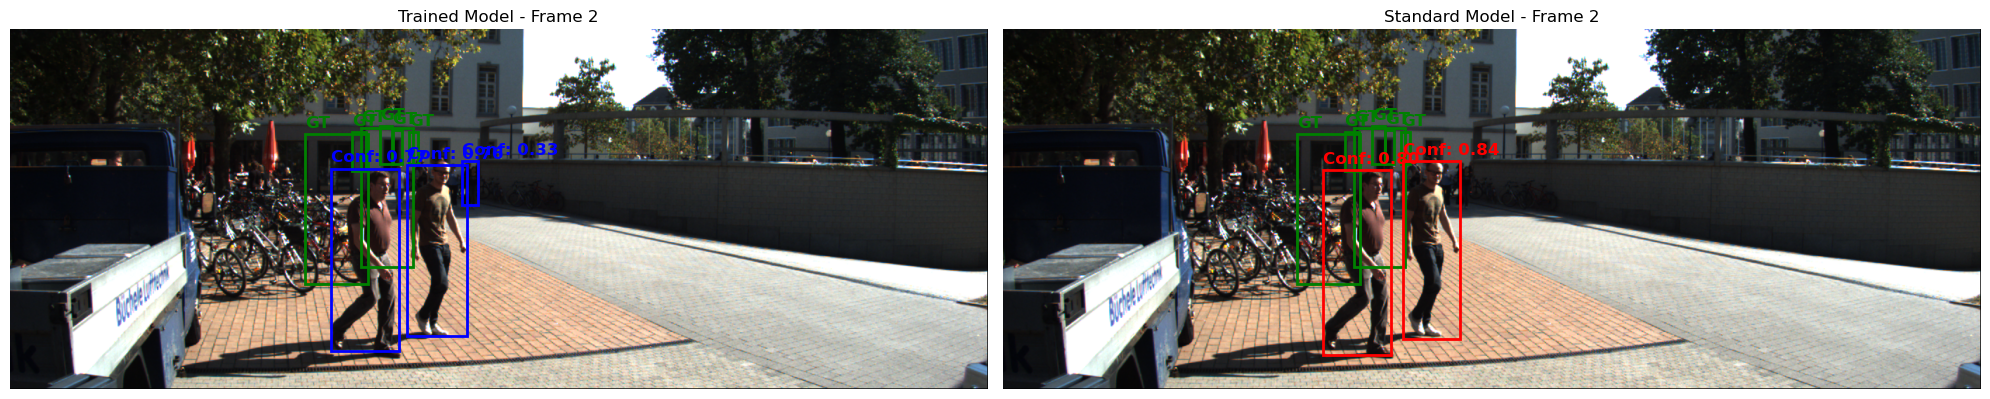

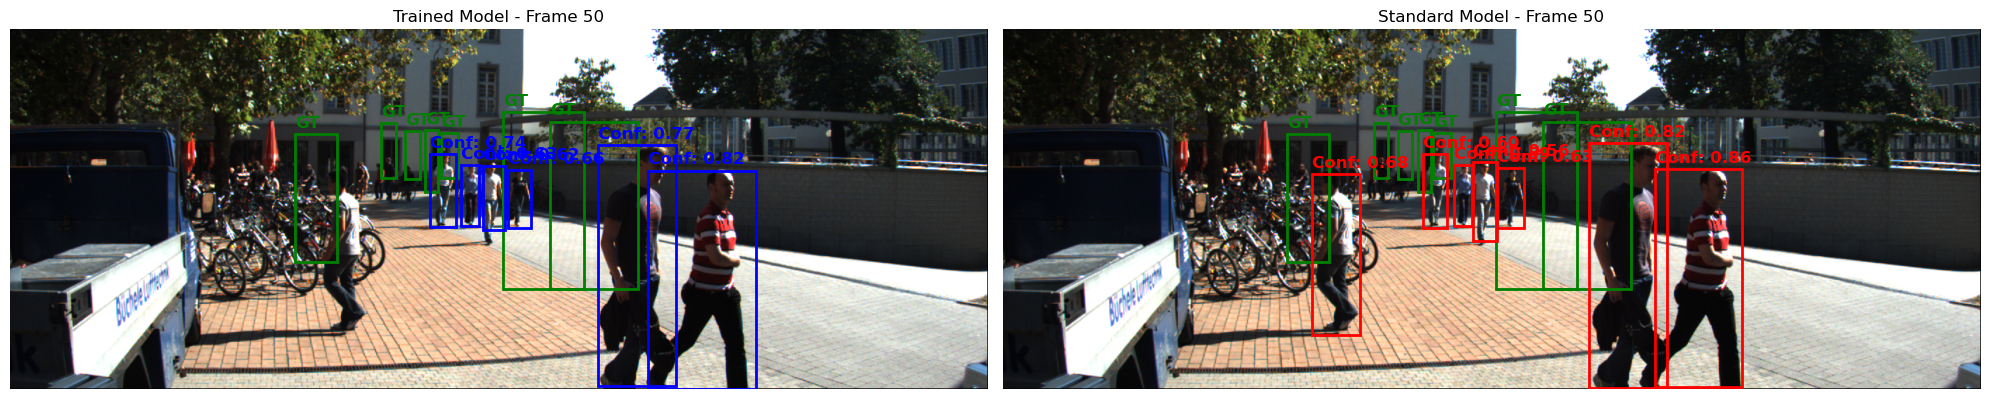

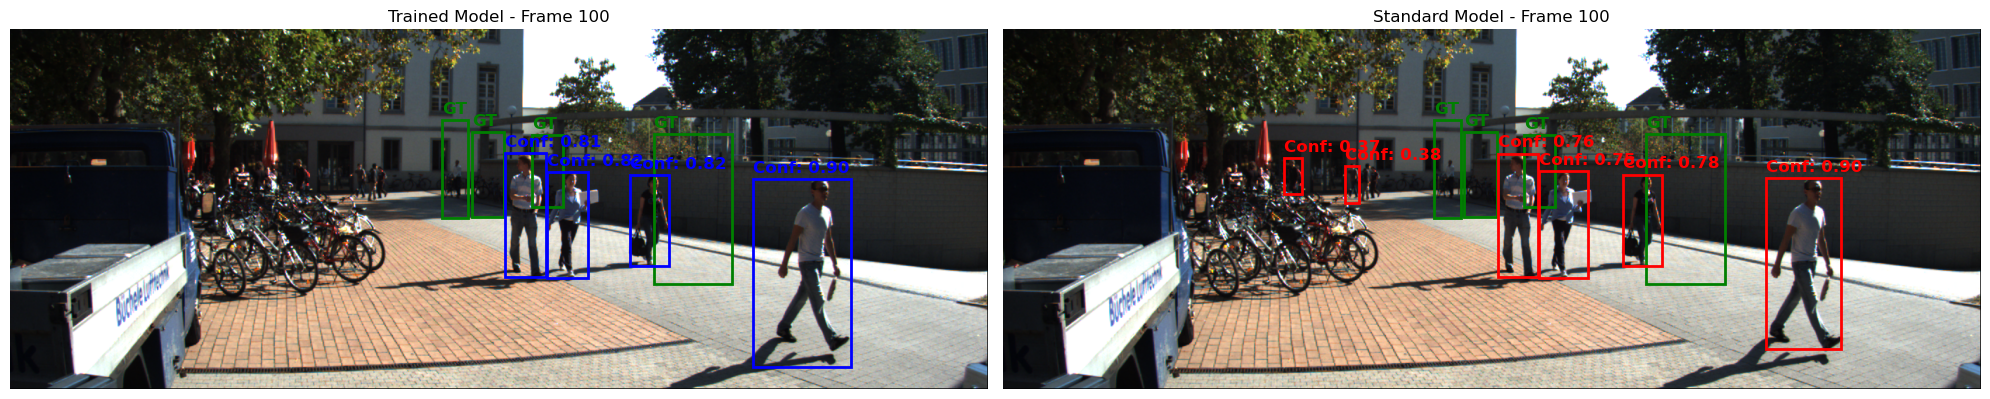

In [6]:
import csv
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLO models
trained_model = YOLO("/home/teitur/perception/Project/perception-final-project/models/yolov8/trained_model.pt")
standard_model = YOLO("yolov8n.pt")

# Load detections for pedestrians
def load_tracking_results(model, image_path):
    results = model(image_path, conf=0.3, verbose=False)
    detections = []
    for box in results[0].boxes:
        cls = int(box.cls[0])
        label = model.names[cls]
        if label == "person":  # Focus only on pedestrians
            x1, y1, x2, y2 = [float(b) for b in box.xyxy[0]]
            detections.append({
                "type": label,
                "bbox": [x1, y1, x2, y2],
                "confidence": float(box.conf[0])  # Extract confidence level
            })
    return detections

# Load ground truth for pedestrians
def load_ground_truth(file_path):
    ground_truths = {}
    with open(file_path, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            frame = int(row[0])
            if row[2] == "Pedestrian":  # Only include pedestrians
                if frame not in ground_truths:
                    ground_truths[frame] = []
                ground_truths[frame].append({
                    "type": row[2],
                    "bbox": [float(row[6]), float(row[7]), float(row[8]), float(row[9])]
                })
    return ground_truths

# Visualization function with confidence levels
def visualize_comparison(frame, trained_detections, standard_detections, ground_truths, image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot trained model results
    axes[0].imshow(img_rgb)
    axes[0].set_title(f"Trained Model - Frame {frame}")
    for gt in ground_truths:
        gt_bbox = gt["bbox"]
        rect = plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2] - gt_bbox[0], gt_bbox[3] - gt_bbox[1],
                             linewidth=2, edgecolor="green", facecolor="none")
        axes[0].add_patch(rect)
        axes[0].text(gt_bbox[0], gt_bbox[1] - 10, "GT", color="green", fontsize=12, fontweight="bold")

    for det in trained_detections:
        det_bbox = det["bbox"]
        rect = plt.Rectangle((det_bbox[0], det_bbox[1]), det_bbox[2] - det_bbox[0], det_bbox[3] - det_bbox[1],
                             linewidth=2, edgecolor="blue", facecolor="none")
        axes[0].add_patch(rect)
        axes[0].text(det_bbox[0], det_bbox[1] - 10, f"Conf: {det['confidence']:.2f}", color="blue", fontsize=12, fontweight="bold")

    # Plot standard model results
    axes[1].imshow(img_rgb)
    axes[1].set_title(f"Standard Model - Frame {frame}")
    for gt in ground_truths:
        gt_bbox = gt["bbox"]
        rect = plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2] - gt_bbox[0], gt_bbox[3] - gt_bbox[1],
                             linewidth=2, edgecolor="green", facecolor="none")
        axes[1].add_patch(rect)
        axes[1].text(gt_bbox[0], gt_bbox[1] - 10, "GT", color="green", fontsize=12, fontweight="bold")

    for det in standard_detections:
        det_bbox = det["bbox"]
        rect = plt.Rectangle((det_bbox[0], det_bbox[1]), det_bbox[2] - det_bbox[0], det_bbox[3] - det_bbox[1],
                             linewidth=2, edgecolor="red", facecolor="none")
        axes[1].add_patch(rect)
        axes[1].text(det_bbox[0], det_bbox[1] - 10, f"Conf: {det['confidence']:.2f}", color="red", fontsize=12, fontweight="bold")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Load ground truth
ground_truth_file = "/home/teitur/perception/Project/34759_final_project_raw/seq_01/labels.txt"
ground_truths = load_ground_truth(ground_truth_file)

# Specify frames to evaluate and visualize
frames_to_evaluate = [2, 50, 100]
image_directory = "/home/teitur/perception/Project/34759_final_project_raw/seq_01/image_02/data"

for frame in frames_to_evaluate:
    image_path = f"{image_directory}/{str(frame).zfill(10)}.png"
    ground_truths_frame = ground_truths.get(frame, [])
    trained_detections = load_tracking_results(trained_model, image_path)
    standard_detections = load_tracking_results(standard_model, image_path)

    visualize_comparison(frame, trained_detections, standard_detections, ground_truths_frame, image_path)
